### Homework 2 - CNN CIFAR 10 
https://www.tensorflow.org/alpha/tutorials/images/intro_to_cnns

pip install tensorflow==2.0.0-alpha0 
or 
pip install tensorflow==2.0.0-alpha0-gpu
1. Loading Dataset
2. Baseline Model
3. Image Augmentation
4. Transfer Learning MobileNetV2

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [8]:
import random


57371

#### 1. Loading Dataset

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [13]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size= 0.2, random_state= random.randint(0, 100000))

In [19]:
train_images = train_images.reshape((train_images.shape[0], 32, 32, 3))
validation_images = validation_images.reshape((validation_images.shape[0], 32, 32, 3))

In [22]:
# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0

In [23]:
train_images.shape, validation_images.shape

((40000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


[6]


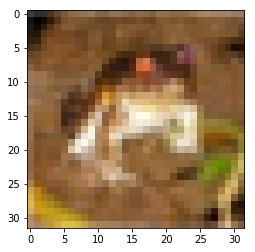

[9]


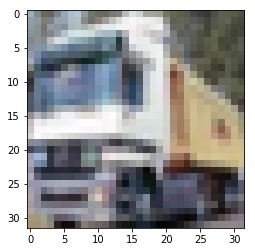

[9]


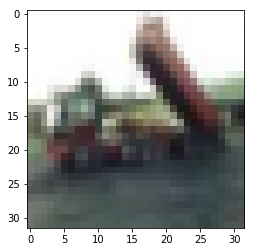

In [7]:
plt.figure()
for x in range(3):
    plt.imshow(train_images[x]) 
    print(train_labels[x])
    plt.show()  # di


### 2. Baseline Model

In [8]:
def baselineModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    #Dense Layers and output
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

In [9]:
model = baselineModel()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model.load_weights('./checkpoints/my_checkpoint')
model.fit(train_images, train_labels, epochs=5, batch_size=50)
model.save_weights("./checkpoints/my_checkpoint")

Epoch 1/5


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d/Conv2D}}]]
	 [[GroupCrossDeviceControlEdges_0/training/Adam/Adam/Const/_71]] [Op:__inference_keras_scratch_graph_1078]

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 133us/sample - loss: 0.9362 - accuracy: 0.6765


In [13]:
print(test_acc)

0.6765


https://www.tensorflow.org/alpha/tutorials/keras/save_and_restore_models

In [14]:
#model.save_weights('./checkpoints/my_checkpoint')

### 3. Image Augmentation

https://www.reddit.com/r/MachineLearning/comments/axq6lu/p_albumentations_an_image_augmentation_library/

pip install -U albumentations

In [15]:
from urllib.request import urlopen

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [48]:
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, RandomRotate90,
    Transpose, ShiftScaleRotate
)

In [17]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [18]:
def show_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()

In [19]:
def augment(aug, image):
    image = aug(image=image)['image']
    return image

Example: https://github.com/albu/albumentations/blob/master/notebooks/example.ipynb

In [20]:
image = download_image('https://therunnersports.com/wp-content/uploads/2019/02/univ-of-central-florida-football-admirable-ucf-knights-of-univ-of-central-florida-football.jpg')

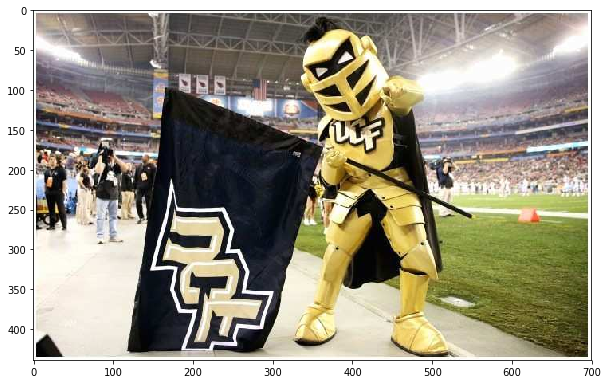

In [21]:
show_image(image)

Horizontal Flip

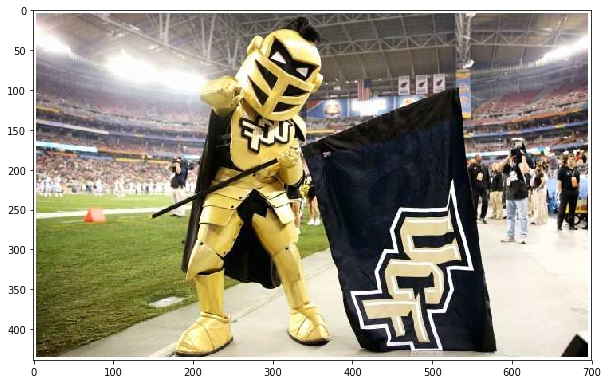

In [22]:
aug = HorizontalFlip(p=1)
show_image(augment(aug,image))

Rotate keep dimensions

0.5


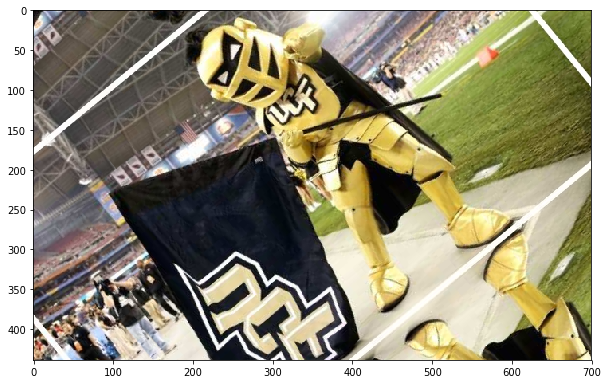

1.0


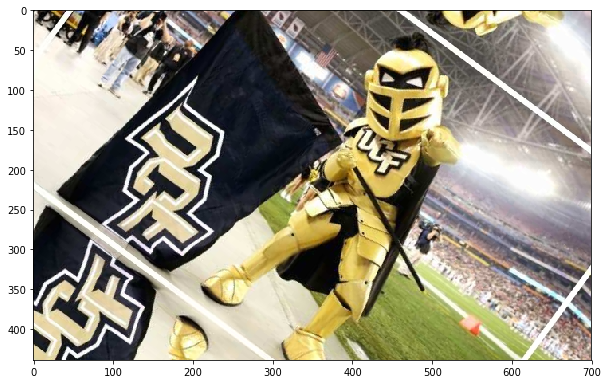

1.5


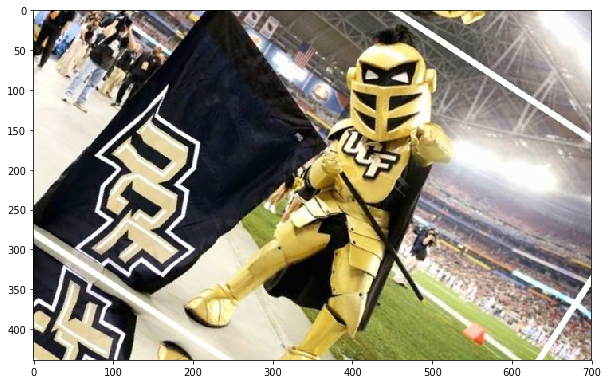

2.0


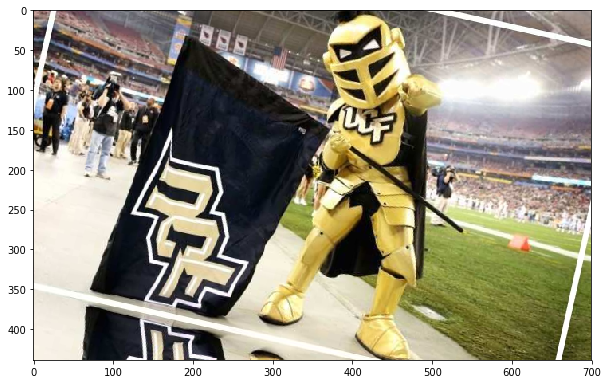

In [36]:
for i in range(1,5):
    aug = ShiftScaleRotate(p=i*.5)
    print(i*.5)
    show_image(augment(aug,image)) 

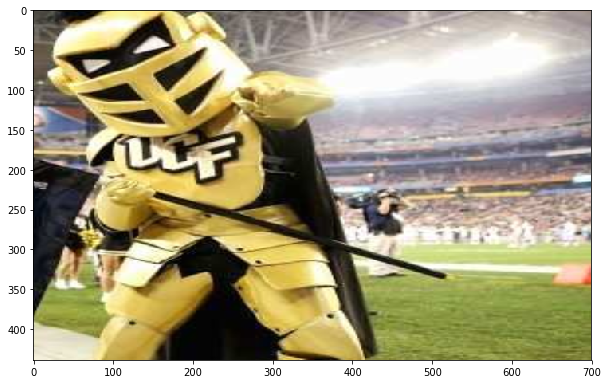

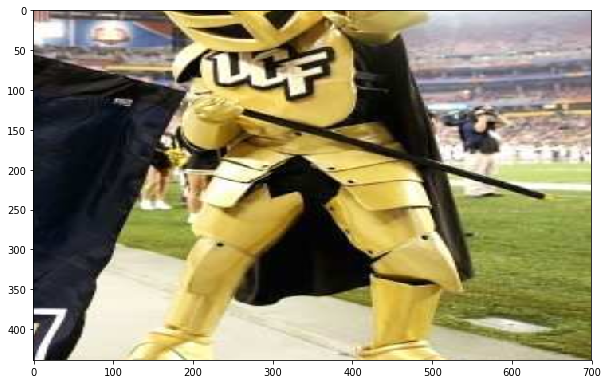

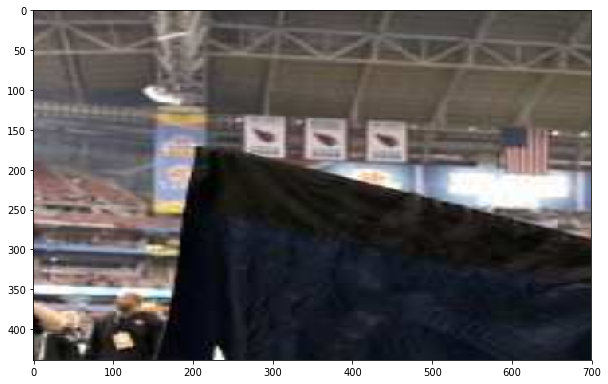

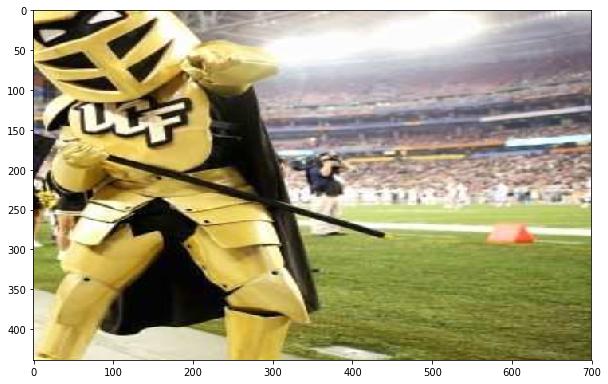

In [37]:
for i in range(1,5):
    aug = RandomSizedCrop(min_max_height=(200, 400), height=439, width=700, p=1)
    show_image(augment(aug,image))

In [38]:
test1 = train_images[:100]
test1.shape

(100, 32, 32, 3)

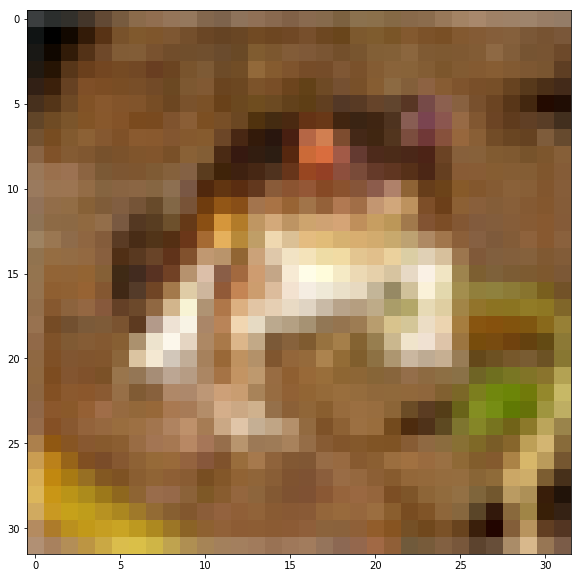

In [39]:
show_image(train_images[0])

In [43]:
#Returns 4 images
def augment_rotate(image, i):
    aug = ShiftScaleRotate(p=i)  
    return aug(image=image)['image']

In [44]:
def preprocessDataset(images, labels):
    size = images.shape[0]
    rotations = [0,.5,1.0,1.5,2.0]
    augmented_images = np.array([augment_rotate(i, j) for i in images for j in rotations])
    augmented_labels = np.array([val for val in labels for _ in range(0, 5)])
    
    return augmented_images, augmented_labels

In [45]:
%%time
newTrainImages, newTrainLabels = preprocessDataset(train_images, train_labels)
print("done")

done
Wall time: 1min 24s


In [46]:
model = baselineModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [47]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(newTrainImages, newTrainLabels, epochs=5, batch_size=50)
model.save_weights('./checkpoints/my_checkpoint2')
#model.load_weights('./checkpoints/my_checkpoint2')

Epoch 1/5
250000/250000 [==============================] - 99s 395us/sample - loss: 1.3348 - accuracy: 0.5212
Epoch 2/5
250000/250000 [==============================] - 97s 386us/sample - loss: 1.0272 - accuracy: 0.6375
Epoch 3/5
250000/250000 [==============================] - 100s 399us/sample - loss: 0.9175 - accuracy: 0.6772
Epoch 4/5
250000/250000 [==============================] - 100s 400us/sample - loss: 0.8432 - accuracy: 0.7037
Epoch 5/5
250000/250000 [==============================] - 97s 389us/sample - loss: 0.7931 - accuracy: 0.7206


In [49]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print(test_acc)

10000/10000 [==============================] - 3s 335us/sample - loss: 0.7818 - accuracy: 0.7339
0.7339


### 4. Transfer Learning
https://www.tensorflow.org/alpha/tutorials/images/transfer_learning

In [50]:
import tensorflow as tf

keras = tf.keras

Format the Data - Needed because it needs to match base model training

using albumentation library to resize https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Resize

In [51]:
from albumentations import (
    Resize
)

In [52]:
#Returns 4 images
def augment_resize(image, height, width):
    aug = Resize(height=height, width=width)  
    return aug(image=image)['image']

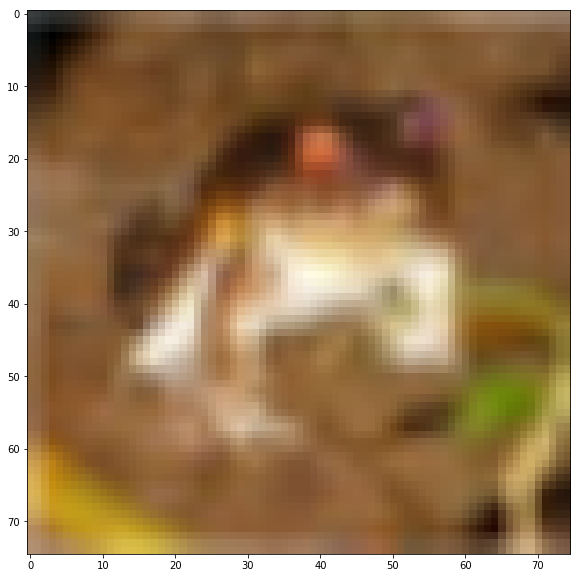

In [53]:
show_image(augment_resize(train_images[0], 75, 75))

In [54]:
def preprocessDatasetResize(images, labels, height, width):
    augmented_images = np.array([augment_resize(i, height, width) for i in images])

    
    return np.float32(augmented_images), labels

In [55]:
%%time
IMG_SIZE = 96 # All images will be resized to 96x96
resized_train_images, train_labels = preprocessDatasetResize(train_images, train_labels, IMG_SIZE, IMG_SIZE)

Wall time: 35.3 s


Feature Extraction Transfer Learning

Mobile Net v2 https://arxiv.org/pdf/1801.04381.pdf

In [56]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)


base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

In [57]:
#output of the pre trained model without the top layer
base_model(resized_train_images[:100]).shape

TensorShape([100, 3, 3, 1280])

Freeze the base model to prevent training on pre trained weights

In [58]:
base_model.trainable = False

In [59]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [60]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [61]:
global_average_layer(base_model(resized_train_images[:100])).shape

TensorShape([100, 1280])

In [62]:
prediction_layer =  models.Sequential()
prediction_layer.add(layers.Dense(64, activation='relu'))
prediction_layer.add(layers.Dense(10, activation='softmax'))

Combine layers

In [63]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [64]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 10)                82634     
Total params: 2,340,618
Trainable params: 82,634
Non-trainable params: 2,257,984
_________________________________________________________________


In [66]:
model.fit(resized_train_images, train_labels, epochs=5, batch_size=50)

Epoch 1/5
50000/50000 [==============================] - 31s 627us/sample - loss: 0.6693 - accuracy: 0.7747
Epoch 2/5
50000/50000 [==============================] - 29s 584us/sample - loss: 0.5154 - accuracy: 0.8246
Epoch 3/5
50000/50000 [==============================] - 29s 576us/sample - loss: 0.4728 - accuracy: 0.8383
Epoch 4/5
50000/50000 [==============================] - 29s 580us/sample - loss: 0.4389 - accuracy: 0.8468
Epoch 5/5
50000/50000 [==============================] - 31s 615us/sample - loss: 0.4144 - accuracy: 0.8541


In [67]:
model.save_weights('./checkpoints/my_checkpoint3')

In [68]:
resized_test_images, test_labels = preprocessDatasetResize(test_images, test_labels, IMG_SIZE, IMG_SIZE)

In [69]:
test_loss, test_acc = model.evaluate(resized_test_images, test_labels)

print(test_acc)

10000/10000 [==============================] - 7s 685us/sample - loss: 0.4901 - accuracy: 0.8339
0.8339


### 5. Combine